# Wind effect on the fire spreading

In this tutorial, we'll explore the effect of wind (both wind power and direction) on fire spreading.

##### Probabilistic Spreading considering the wind factor
Building on our previous probabilistic model, we take wind into account in this model. To get a perfect forest fire spreading model, both wind power and wind direction and their interaction cannot be ignored. To consider the change of central cell (i, j) after a time period, we need to study the eight neighborhood cells’ impact on the central cell. 

In real fires, wind helps fuel the flames and cause the fire to grow, rarely having a dampening effect on the fire's growth. Below, we attempt to translate this phenomenon into our model.

We start off by creating a 25 by 25 world and assume the whole forest is burnable.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib as mpl
import matplotlib.pyplot as plt

empty = 0
unburned = 1
burning = 2 
burned = 3

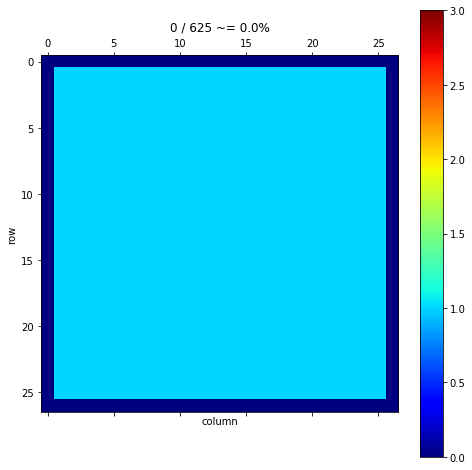

In [2]:
def create_world(n, q):
    world = np.zeros((n+2, n+2))
    forest = world[1:-1, 1:-1]
    forest[:, :] = np.random.choice([0, 1], p=[1-q, q], size=(n, n))
    return world

def show_world(W, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'jet'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 3
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    if title is None:
        num_trees = (W > 0).sum()
        if num_trees > 0:
            num_burnt = (W == 3).sum()
            percent = num_burnt / num_trees * 1e2
            title = '{} / {} ~= {:.1f}%'.format(num_burnt, num_trees, percent)
        else:
            title = ''
    plt.title(title)
    pass

World = create_world(25, 1)
show_world(World)

In [3]:
def is_empty(W):
    return W == empty

def is_vegetation(W):
    return W > empty

def is_unburned(W):
    return W == 1

def is_burning(W):
    return W == 2

def is_burned(W):
    return W == 3

def count(W, cond_fun):
    return cond_fun(W).sum()

def summarize_world(W):
    def suffix(n):
        return (1, "tree") if n == 1 else (n, "trees")
    m, n = W.shape[0]-2, W.shape[1]-2
    n_trees = count(W, is_vegetation)
    n_unburned = count(W, is_unburned)
    n_burning = count(W, is_burning)
    n_burned = count(W, is_burned)
    
    print("The world has dimensions: {} x {}".format(m, n))
    print("There are {} cell(s) that have had vegetation in them".format(n_trees))
    print("There are {} cell(s) of vegetation that are unburned".format(n_unburned))
    print("There are {} cell(s) of vegetation on fire".format(n_burning))
    print("There are {} cell(s) of vegetation completely burned".format(n_burned))

summarize_world(World)

The world has dimensions: 25 x 25
There are 625 cell(s) that have had vegetation in them
There are 625 cell(s) of vegetation that are unburned
There are 0 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


The world has dimensions: 25 x 25
There are 625 cell(s) that have had vegetation in them
There are 624 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


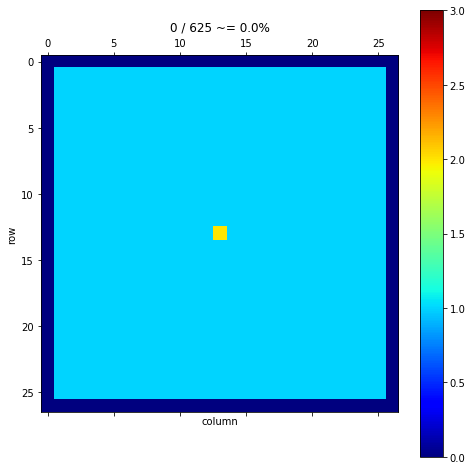

In [4]:
# In order to show the effect of the wind direction on the fire spreading, we set the fire starting point as the middle point of the world

def start_fire(W, m, cells=None):
    # m is true for the middle point, false for the random point
    W_new = W.copy()
    if m == True:
        middle = int(len(World)/2)
        W_new[middle,middle]=2
        return W_new
    else:
        if cells == None:
            F = W[1:-1, 1:-1]
            W_new = W.copy()
            F_new = W_new[1:-1, 1:-1]
            I, J = np.where(is_unburned(F)) # Positions of all trees
            if len(I) > 0:
                k = np.random.choice(range(len(I))) # Index of tree to ignite
                i, j = I[k], J[k]
                assert F_new[i, j] == 1, "Attempting to ignite a non-tree?"
                F_new[i, j] += 1
        else:
            W_new = W.copy()

            for x,y in cells:
                W_new[x,y] = 2
    
    return W_new
# Start a fire in the world, middle for True and random for False
World_next = start_fire(World,True)
show_world(World_next)
summarize_world(World_next)

### Wind factor
Our wind factor can be decomposed into 2 parts: wind direction and wind power. We combine these two to create a new wind weight that translates to higher probabilities of ignition for cells downwind from a fire.

Here, we have 8 directions for wind, and we assume the wind power is scaled greater than 1. Additionally, we assume the effect of the wind power on the fire spreading is linear.


_Note:_ Wind direction in our model is the direction where wind blows to. e.g. N wind will affect the cell above the burning cell.

The world has dimensions: 25 x 25
There are 625 cell(s) that have had vegetation in them
There are 621 cell(s) of vegetation that are unburned
There are 3 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


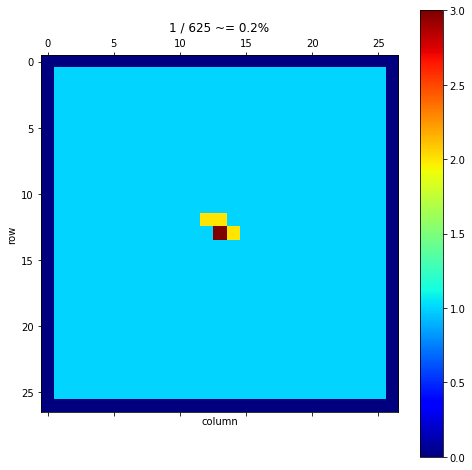

In [5]:
# Probability of fire spread
fire_spread_prob = 0.3

def spread_fire(W, wind_dir, wind_power):
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    
    #identify the 8 neighbors of the burning cell
    F1 = Fires[:-2, :-2]
    F2 = Fires[1:-1, :-2]
    F3 = Fires[2:, :-2]
    F4 = Fires[:-2, 1:-1]
    F5 = Fires[2:, 1:-1] 
    F6 = Fires[:-2, 2:]
    F7 = Fires[1:-1, 2:]
    F8 = Fires[2:, 2:]
    
    # Add the wind direction and wind power effect on the probabilibty
    # There are 8 neighbors 1-8, and we consider 8 wind directions N S W E WN EN WS ES. 
    # Then assign different weights to the probability for all 8 neighbors of the cell
    
    if wind_dir =='S':
        F4 = F4 *wind_power
        F5 = F5 *0   
    elif wind_dir =='N':
        F5 = F5 *wind_power
        F4 = F4 *0
        
    elif wind_dir =='W':
        F7 = F7 *wind_power
        F2 = F2 * 0    
        
    elif wind_dir =='E':
        F2 = F2 *wind_power
        F7 = F7 * 0 
        
    elif wind_dir =='SW':
        F6 = F6 *wind_power
        F3 = F3 *0
    elif wind_dir =='SE':
        F1 = F1 *wind_power
        F8 = F8 *0
        
    elif wind_dir =='NW':
        F8 = F8 *wind_power
        F1 = F1 *0
    elif wind_dir =='NE':
        F3 = F3 *wind_power
        F6 = F6 *0

    # Spread fire to neighbors
    # First count how many neighbors of a cell are on fire!
    num_neighbors_on_fire = (F1 + F2+F3+ F4+ F5+ F6 + F7+ F8)

    # If there's no vegetation at a certain spot, we don't want to calculate anything related to it's neighbors,
    # so lets set those locations to zero
    num_neighbors_on_fire = np.multiply(num_neighbors_on_fire, Vegetation[1:-1, 1:-1].astype(int))
            
    # Now calcualte the chance of each location doesn't catch fire at the next time-step.
    # All probabilities start out as 1.0 - fire_spread_prob
    fire_prob_matrix = np.ones(num_neighbors_on_fire.shape) - fire_spread_prob
    
    # Because each neighbor independently influences a cell, the total probability of not spreading is equal to
    # the (probabilty of one neighbor not spreading) ^ (number of neighbors). Taking 1.0 - that value transforms the
    # calculated probability to represent the: probability of the cell catching on fire due to any of the neighbors.
    fire_prob_matrix = 1.0 - np.power(fire_prob_matrix, num_neighbors_on_fire) 

    # Again we don't care about a specific cell's value if there's no vegetation there, so we zero out
    # the locations that don't have vegetation there!
    fire_prob_matrix = np.multiply(fire_prob_matrix, Vegetation[1:-1, 1:-1].astype(int))
    
    # Now to use our probabiltiy matrix we've generated, we need to generate a matrix of all random 
    # values between 0.0 and 1.0, and compare if the random generated value is less than the probability of catching fire!
    randys = np.random.rand(*fire_prob_matrix.shape)
    new_on_fires = randys < fire_prob_matrix
    
    # Now we "add" one to each location that used to be "unburned" that now will be "burning" since the value for
    # "unburned" is (1) and the value for "burning" is (2), this works out to transition our states perfectly!
    W_new[1:-1, 1:-1] += new_on_fires
 
    # We still want to extinguish current fires after one time-step, so let's go do that
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]

    # Aaaaand we're done!
    return W_new

# Spread one time-step of fire. Then show and summarize the world! 
# We can assign the wind direction'NW'and power 3 here.
World_next = spread_fire(World_next,'NW',3)
show_world(World_next)
summarize_world(World_next)

Then we pick a direction 'NW' and a wind power of 3 to confirm that the wind has large impact to the fire spreading. When running simulations, we can see that the left upper corner of the forest is almost on fire.

The world has dimensions: 25 x 25
There are 625 cell(s) that have had vegetation in them
There are 435 cell(s) of vegetation that are unburned
There are 36 cell(s) of vegetation on fire
There are 154 cell(s) of vegetation completely burned


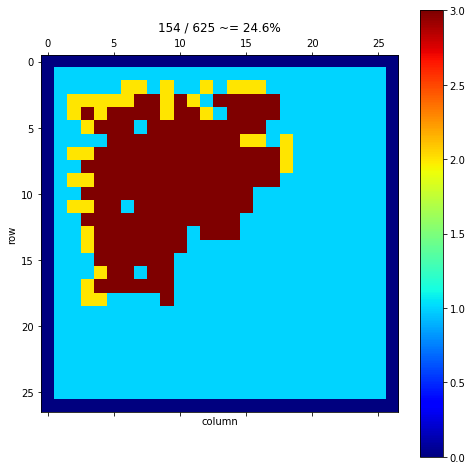

In [6]:
for _ in range(10):
    World_next = spread_fire(World_next,'NW',3)

show_world(World_next)
summarize_world(World_next)

### Simulation

Below, we run some Monte Carlo simulations as in the first couple of tutorials to see the effect of wind direction and wind speed on our fire's spread.

In [7]:
def simulate(W0, wind_dir,wind_power, t_max=None, inplace=False):
    if t_max is None:
        n_max = max(W0.shape)
        t_max = n_max * ((2*n_max-1) // 2)
    W = np.zeros((W0.shape[0], W0.shape[1], 2 if inplace else t_max+1))
    t_cur = 0
    W[:, :, t_cur] = W0
    for t in range(t_max):
        t_next = (t_cur+1)%2 if inplace else t+1
        W[:, :, t_next] = spread_fire(W[:, :, t_cur],wind_dir,wind_power)
        if (W[:, :, t_cur] == W[:, :, t_next]).all():
            t_cur = t_next
            break
        t_cur = t_next
    return (W[:, :, t_cur], t) if inplace else W[:, :, :t_cur+1]
    
def viz(W, t=0):
    show_world(W[:, :, t])
    plt.show()
    print("At time {} (max={})...".format(t, W.shape[2]-1))
    summarize_world(W[:, :, t])
    
def run_simulation(n, q, wind_dir, wind_power, **args):
    w = create_world(n, q)
    # start the fire randomly in the forest
    w = start_fire(w,False)
    
    return simulate(w, wind_dir,wind_power, **args)

In [8]:
def simulate_many(n, q,trials, wind_dir, wind_power):
    percent_burned = np.zeros(trials)
    time_to_burn = np.zeros(trials)
    for trial in range(trials):
        W_last, t_last = run_simulation(n, q, wind_dir,wind_power,inplace=True)
        n_trees = count(W_last, is_vegetation)
        n_burnt = count(W_last, is_burned)
        percent_burned[trial] = n_burnt / n_trees if n_trees > 0 else 0.0
        time_to_burn[trial] = t_last
    return percent_burned, time_to_burn

### Wind direction analysis

In [9]:
n_many = 25
wind_dir = ['N','S', 'W', 'E', 'NW','NE','SW','SE']
Percentages = np.zeros((len(wind_dir), 2))
Times = np.zeros((len(wind_dir), 2))

for k, w in enumerate(wind_dir):
    print("Simulating wind direction:{}...".format(w))
    # iterate through wind_dir and set the wind power as constant 5
    percentages, times = simulate_many(n_many, 1, 100, w, 5)
    Percentages[k, :] = [percentages.mean(), percentages.std()]
    Times[k, :] = [times.mean(), times.std()]
    

Simulating wind direction:N...
Simulating wind direction:S...
Simulating wind direction:W...
Simulating wind direction:E...
Simulating wind direction:NW...
Simulating wind direction:NE...
Simulating wind direction:SW...
Simulating wind direction:SE...


From the plot below, we observe that the fraction of trees burned varies among 8 wind directions. The directions of _NW, NE, SW, SE_ wind are less than _N, S, W, E_. This could be attributed to the format of our CA. For instance, in the row or column order directions of _N, S, W, E_, the wind is blowing along one of the axis of our 2d square world and thus has higher exposure to cells than going diagonally to one of the corners of our grid world.

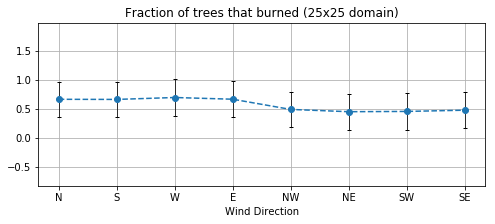

In [10]:
plt.figure(figsize=(8, 3))
plt.errorbar(wind_dir, Percentages[:, 0], yerr=Percentages[:, 1], fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
plt.gca().axis('equal')
plt.xlabel('Wind Direction');
plt.title('Fraction of trees that burned ({}x{} domain)'.format(n_many, n_many));
plt.grid()

Below we can see the burning time of the different worlds. Although the diagonal directions appear to burn through the forest faster, they were also consistently burning less forest before going out as our plot above revealed and thus it make sense for these fires to take less time.

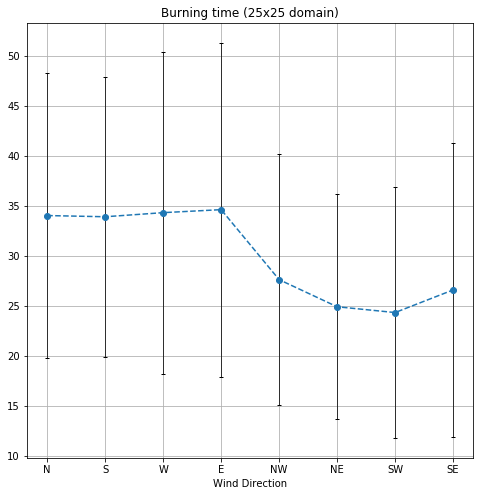

In [11]:
plt.figure(figsize=(8, 8))
Z = 1 
plt.errorbar(wind_dir, Times[:, 0]/Z, yerr=Times[:, 1]/Z,
             fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
plt.xlabel('Wind Direction');
plt.title('Burning time ({}x{} domain)'.format(n_many, n_many));
plt.grid()

### Wind Power Analysis

Here we want to see how the wind power will affect the fire spreading. We set the wind direction as 'N' for testing.

In [12]:
n_many = 25
wind_power = np.linspace(1, 10, 10)
Percentages = np.zeros((len(wind_power), 2))
Times = np.zeros((len(wind_power), 2))

for k, w in enumerate(wind_power):
    print("Simulating wind direction:{}...".format(w))
    # iterate through wind power and set the wind direction as 'N'
    percentages, times = simulate_many(n_many, 1, 100, 'N', w)
    Percentages[k, :] = [percentages.mean(), percentages.std()]
    Times[k, :] = [times.mean(), times.std()]

Simulating wind direction:1.0...
Simulating wind direction:2.0...
Simulating wind direction:3.0...
Simulating wind direction:4.0...
Simulating wind direction:5.0...
Simulating wind direction:6.0...
Simulating wind direction:7.0...
Simulating wind direction:8.0...
Simulating wind direction:9.0...
Simulating wind direction:10.0...


From the plot, we can see that higher wind power will contribute to a higher fraction of the forest being burned.

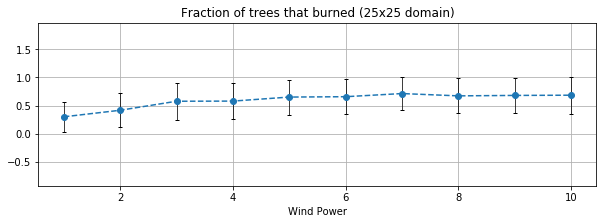

In [13]:
plt.figure(figsize=(10, 3))
plt.errorbar(wind_power, Percentages[:, 0], yerr=Percentages[:, 1], fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
plt.gca().axis('equal')
plt.xlabel('Wind Power');
plt.title('Fraction of trees that burned ({}x{} domain)'.format(n_many, n_many));
plt.grid()